In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
import seaborn as sns 

In [2]:
torch.manual_seed(1)

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        # self.conv1 = nn.Conv2d(1, 6, 5)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(784, 500)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        # x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [6]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt={}
    trainAvgLossArr = []
    trainAvgAccArr = []
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)
            
            # #Weight Collection
            # if epoch % 3 == 0:
            #     for name, parameter in model.named_parameters():
            #         #print(name)
            #         if'weight' in name:
            #             modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
            #             print(modelParamWgt)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                print(modelParamWgt)       
                        
        epochLoss = lossSum/(i+1)
        epochAcc = totalacc/(i+1)
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt

In [7]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [8]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    scale = StandardScaler()

    sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(sData)

    itrData = np.full((pcaVal.shape[0],1),itr)

    #pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [9]:
#2nd Approach

max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 100
test_batch_size = 100
status_interval = 50
loss_func = nn.CrossEntropyLoss()

for count in range(8):
    print("Time: "+str(count))
    M = DNN()
    optimizer = torch.optim.Adam(M.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times: "+str(count)    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt = trainFunc(M,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(M,loss_func,test_batch_size)

    temp_df = pd.DataFrame(modelParamWgt).transpose()
    all_df = all_df.append(temp_df)
    

    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr





Time: 0
strated
{1: array([-8.4060164e-16, -3.1328411e-16,  1.3718551e-16, ...,
       -3.6429803e-14,  4.7069747e-17,  1.1607254e-16], dtype=float32)}
{1: array([ 0.06529455, -0.03570282, -0.1362069 , ..., -0.05825929,
        0.03834577,  0.02911522], dtype=float32)}
{1: array([ 0.06529455, -0.03570282, -0.1362069 , ..., -0.05825929,
        0.03834577,  0.02911522], dtype=float32), 2: array([ 1.7093265e-29, -1.1226930e-29,  7.4556312e-31, ...,
       -1.4230244e-27, -1.6013152e-30,  1.4512121e-29], dtype=float32)}
{1: array([ 0.06529455, -0.03570282, -0.1362069 , ..., -0.05825929,
        0.03834577,  0.02911522], dtype=float32), 2: array([ 0.064262  , -0.02378424, -0.1862729 , ..., -0.0653091 ,
        0.04074679,  0.03442317], dtype=float32)}
{1: array([ 0.06529455, -0.03570282, -0.1362069 , ..., -0.05825929,
        0.03834577,  0.02911522], dtype=float32), 2: array([ 0.064262  , -0.02378424, -0.1862729 , ..., -0.0653091 ,
        0.04074679,  0.03442317], dtype=float32), 3: arra

In [10]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [11]:
np.shape(trainAccArr)

(8, 45)

In [12]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(360,) & Shape of Acc: (360,)


In [13]:
t1 = all_df
print(pd.DataFrame(t1))

        0         1         2         3         4         5         6     \
1   0.065295 -0.035703 -0.136207 -0.103087 -0.062495  0.012414 -0.083528   
2   0.064262 -0.023784 -0.186273 -0.161112 -0.072895  0.024532 -0.086243   
3   0.065100 -0.013734 -0.235640 -0.207833 -0.088603  0.065081 -0.085231   
4   0.065933 -0.009858 -0.283627 -0.239819 -0.104963  0.088378 -0.085706   
5   0.065036 -0.011549 -0.325935 -0.268537 -0.122695  0.094679 -0.088956   
..       ...       ...       ...       ...       ...       ...       ...   
41  0.098214  0.099054  0.156994  0.067135  0.008780  0.207515  0.110499   
42  0.095069  0.098039  0.160976  0.071468  0.011650  0.205733  0.106916   
43  0.099754  0.102657  0.168509  0.073616  0.019129  0.207157  0.111250   
44  0.102488  0.104231  0.169354  0.072766  0.021122  0.207196  0.109542   
45  0.103530  0.098000  0.160494  0.070190  0.025904  0.213131  0.109910   

        7         8         9     ...      4990      4991      4992      4993  \
1   0.

In [14]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['eps']=eps_each_time
allEpochDf['time']=times
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf


,x,y,eps,time,Acc,Loss
0,0.582568,-0.626206,0,0,82.932006,0.410574
1,0.762791,-0.832298,1,0,94.140449,0.185431
2,0.913266,-0.994446,2,0,96.033236,0.132638
3,1.042660,-1.132691,3,0,97.002958,0.102216
4,1.160589,-1.250416,4,0,97.683006,0.083211
...,...,...,...,...,...,...
355,9.016992,-1.833538,40,7,99.948650,0.009534
356,9.041371,-1.839014,41,7,99.949615,0.009487
357,9.054903,-1.845556,42,7,99.921330,0.009258
358,9.071033,-1.848776,43,7,99.936779,0.008939


In [15]:
epoch3Df = allEpochDf.loc[(allEpochDf['eps']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,eps,time,Acc,Loss
0,0.913266,-0.994446,2,0,96.033236,0.132638
1,1.268323,-1.362666,5,0,98.116560,0.069274
2,1.550878,-1.661014,8,0,98.744407,0.045048
3,1.799168,-1.908746,11,0,99.242878,0.031745
4,2.012275,-2.119262,14,0,99.563895,0.022795
...,...,...,...,...,...,...
115,8.730771,-1.794127,32,7,99.947238,0.009698
116,8.869558,-1.824968,35,7,99.935111,0.010137
117,8.965184,-1.830830,38,7,99.941901,0.009644
118,9.041371,-1.839014,41,7,99.949615,0.009487


In [16]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
mv

['96',
 '98',
 '98',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '96',
 '98',
 '98',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '96',
 '98',
 '98',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '96',
 '98',
 '98',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '95',
 '98',
 '98',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '96',
 '98',
 '98',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '96',
 '98',
 '98',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '95',
 '98',
 '98',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99']

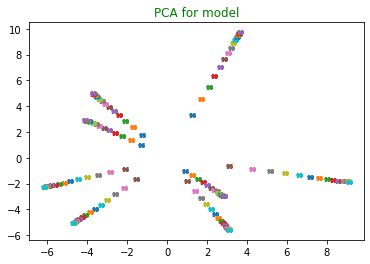

In [17]:
for i in range(len(mv)):
    m = mv[i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$')
    plt.title("PCA for model",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_1.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()